# AI-Driven CO2 Injection Control using JAX-LaB

## 1. Introduction
This notebook implements a differentiable physics simulation to optimize **Carbon Capture and Storage (CCS)** injection strategies. Specifically, it tackles the "salting-out" problem: finding an injection pressure schedule $P(t)$ that maximizes $CO_2$ storage while preventing salt precipitation from clogging the reservoir rock.

### Methodology
We use **JAX-LaB**, a differentiable Lattice Boltzmann Method (LBM) solver. Unlike traditional "black-box" simulators, this approach allows us to differentiate through the fluid physics. We can calculate the exact gradient of the storage efficiency with respect to the injection pressure schedule $\nabla_P \mathcal{L}$ and use gradient descent to discover optimal control strategies.

### The Physics Model
* **Multiphase Flow:** Shan-Chen pseudopotential model for immiscible $scCO_2$ displacing brine.
* **Salt Precipitation:** Coupled advection-diffusion of salt, where high concentration leads to solid precipitation (porosity reduction).
* **Objective:** Maximize saturation $S_{CO2}$ while minimizing energy usage and fracture risk (penalizing high $P^2$).

In [1]:
import jax
import jax.numpy as jnp
from jax import grad, jit, lax, value_and_grad, checkpoint
import optax
import matplotlib.pyplot as plt
import numpy as np

# Enable 64-bit precision for numerical stability in multiphase flows
jax.config.update("jax_enable_x64", True)

# --- Physical Constants (Based on Source 1, Table 1) ---
NX, NY = 100, 50       # Domain size
TAU_BRINE = 1.0        # Relaxation time (Brine)
TAU_CO2 = 0.6          # Relaxation time (CO2) - Lower viscosity to match M=2 ratio
G_INT = -1.2           # Shan-Chen Interaction Strength (controls surface tension)
RHO_BRINE = 1.0        # Base density Brine
RHO_CO2_INIT = 0.1     # Base density CO2
D_SALT = 0.05          # Salt diffusion coefficient
K_SP = 1.1             # Solubility product threshold (Precipitation limit)

# Lattice Weights (D2Q9 model)
W = jnp.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
CX = jnp.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
CY = jnp.array([0, 0, 1, 0, -1, 1, 1, -1, -1])

print("JAX-LaB Environment Configured.")

JAX-LaB Environment Configured.


## 2. Differentiable LBM Kernels
These functions define the physics engine. They are "pure functions" (no side effects) so JAX can trace them for automatic differentiation. We implement the **Shan-Chen** forces to model the separation between $CO_2$ and Brine.

In [2]:
# --- Corrected Cell 2: Robust LBM Kernels ---

@jit
def get_equilibrium(rho, u_x, u_y):
    """
    Calculates Equilibrium Distribution (f_eq).
    Handles both scalar inputs (Boundary Condition) and array inputs (Field).
    """
    # 1. Expand dimensions for broadcasting if inputs are arrays
    # If u_x is (NX, NY), make it (NX, NY, 1) to multiply with CX (9,)
    # If u_x is scalar, this adds a dimension making it (1,), which also works.
    u_x_exp = jnp.expand_dims(u_x, axis=-1)
    u_y_exp = jnp.expand_dims(u_y, axis=-1)
    rho_exp = jnp.expand_dims(rho, axis=-1)

    u_sq = u_x**2 + u_y**2
    u_sq_exp = jnp.expand_dims(u_sq, axis=-1)
    
    # Calculate dot product: e_i * u
    eu = (CX * u_x_exp + CY * u_y_exp)
    
    return rho_exp * W * (1.0 + 3.0*eu + 4.5*eu**2 - 1.5*u_sq_exp)

@jit
def interaction_force(rho, G):
    """Shan-Chen Multiphase Force (Isotropic)."""
    # Clip rho to prevent exp explosion
    rho_safe = jnp.clip(rho, 1e-3, 5.0)
    psi = 1 - jnp.exp(-rho_safe)
    
    psi_xp = jnp.roll(psi, -1, axis=0)
    psi_xm = jnp.roll(psi, 1, axis=0)
    psi_yp = jnp.roll(psi, -1, axis=1)
    psi_ym = jnp.roll(psi, 1, axis=1)
    
    fx = -G * psi * (psi_xp - psi_xm)
    fy = -G * psi * (psi_yp - psi_ym)
    return fx, fy

@jit
def collision_stream(f, salt_conc, mask, tau):
    """Collision & Streaming with Stability Clips."""
    # 1. Moments
    rho = jnp.sum(f, axis=-1)
    rho_safe = jnp.maximum(rho, 1e-3) # Prevent div by zero
    
    u_x = jnp.sum(f * CX, axis=-1) / rho_safe
    u_y = jnp.sum(f * CY, axis=-1) / rho_safe
    
    # Stability: Clip macroscopic velocity
    u_x = jnp.clip(u_x, -0.4, 0.4)
    u_y = jnp.clip(u_y, -0.4, 0.4)
    
    # 2. Forces
    fx, fy = interaction_force(rho, G_INT)
    u_x += fx / rho_safe
    u_y += fy / rho_safe
    
    # 3. Salt Drag
    precip_factor = jax.nn.sigmoid(10 * (salt_conc - K_SP)) 
    u_x *= (1.0 - precip_factor) 
    u_y *= (1.0 - precip_factor)

    # 4. Relaxation
    f_eq = get_equilibrium(rho, u_x, u_y)
    
    # Expand tau for broadcasting (NX, NY) -> (NX, NY, 1)
    tau_exp = jnp.expand_dims(tau, axis=-1)
    f_out = f - (f - f_eq) / tau_exp
    
    # 5. Streaming
    for i in range(9):
        f_out = f_out.at[..., i].set(jnp.roll(f_out[..., i], (CX[i], CY[i]), axis=(0, 1)))
        
    # 6. Bounce-back
    mask_exp = jnp.expand_dims(mask, axis=-1)
    f_out = f_out * (1 - mask_exp) + f * mask_exp
    
    # 7. Final Nan Check
    f_out = jnp.nan_to_num(f_out, nan=0.0)
    return f_out, rho, u_x, u_y

## 3. The Physics Step & Time Integration
Here we define the single timestep function `lbm_step`. This includes:
1.  **Dynamic Boundary Condition:** Converting the learnable pressure parameter $P(t)$ into an inlet density.
2.  **Salt Transport:** Solving the advection-diffusion equation for salinity.
3.  **Precipitation:** Updating the solid mask if salinity exceeds the solubility limit.

**Note:** We use `jax.checkpoint` (also known as `remat`) to manage GPU memory. This allows us to run thousands of time steps by trading compute time for memory during backpropagation.

In [3]:
# --- Corrected Cell 3: Stable Physics Loop ---

@checkpoint
def lbm_step(carry, pressure_in):
    f, salt, mask = carry
    
    # 1. Inlet BC: Clip pressure to safe range
    p_safe = jnp.clip(pressure_in, 0.0, 0.2) 
    # Reduced coupling strength (1.0 instead of 3.0) to prevent shockwaves
    rho_inlet = RHO_BRINE + p_safe * 1.0 
    
    # Set inlet (Left wall)
    # Using scalar inputs for u_x, u_y (0.1, 0.0)
    f_inlet = get_equilibrium(rho_inlet, 0.1, 0.0)
    f = f.at[0, :, :].set(f_inlet)
    
    # 2. Tau Calculation (Safe)
    rho_local = jnp.sum(f, axis=-1)
    tau_eff = TAU_CO2 + (TAU_BRINE - TAU_CO2) * (rho_local - RHO_CO2_INIT)/(RHO_BRINE - RHO_CO2_INIT)
    # CRITICAL: Tau must be > 0.5. We clip to 0.55.
    tau_safe = jnp.maximum(tau_eff, 0.55)
    
    # 3. LBM Step
    f_new, rho, ux, uy = collision_stream(f, salt, mask, tau_safe)
    
    # 4. Salt Transport (Stable Upwind-ish Advection)
    # Clip advection velocity specifically for salt transport
    ux_s = jnp.clip(ux, -0.2, 0.2)
    uy_s = jnp.clip(uy, -0.2, 0.2)
    
    # Central difference for gradients
    grad_salt_x = (jnp.roll(salt, -1, axis=0) - jnp.roll(salt, 1, axis=0)) / 2.0
    grad_salt_y = (jnp.roll(salt, -1, axis=1) - jnp.roll(salt, 1, axis=1)) / 2.0
    laplacian = (jnp.roll(salt, -1, axis=0) + jnp.roll(salt, 1, axis=0) + 
                 jnp.roll(salt, -1, axis=1) + jnp.roll(salt, 1, axis=1) - 4*salt)
    
    # Update salt
    salt_new = salt + (-(ux_s * grad_salt_x + uy_s * grad_salt_y) + D_SALT * laplacian)
    
    # BC: Fresh CO2 at inlet has 0 salt
    salt_new = salt_new.at[0, :].set(0.0)
    salt_new = jnp.clip(salt_new, 0.0, 5.0) # Prevent divergence
    
    # 5. Precipitation
    new_precip = jax.nn.sigmoid(20 * (salt_new - K_SP))
    mask_new = jnp.maximum(mask, new_precip)
    
    # 6. Metrics
    # Avoid NaN in saturation calc if mask fills domain
    pore_volume = jnp.sum(1-mask_new) + 1e-6
    is_co2 = rho < (RHO_BRINE + RHO_CO2_INIT) / 2.0
    s_co2 = jnp.sum(is_co2 * (1-mask_new)) / pore_volume
    
    # Final safeguard
    f_new = jnp.nan_to_num(f_new)
    
    return (f_new, salt_new, mask_new), s_co2

def run_simulation(pressure_schedule, initial_state):
    return lax.scan(lbm_step, initial_state, pressure_schedule)

## 4. Optimization Setup
We define the loss function $\mathcal{L}$ to balance storage efficiency (Maximize Saturation) and energy cost (Minimize Pressure). 

$$\mathcal{L}(P_{in}) = (1 - S_{CO2}(T))^2 + \lambda \sum (P_{in}(t))^2$$

We use the **Adam** optimizer to update the pressure schedule $P(t)$.

In [4]:
def loss_fn(pressure_schedule, initial_state):
    """
    Composite Loss Function.
    """
    LAMBDA_ENERGY = 0.05 # Regularization weight
    
    # Forward Pass
    final_state, s_hist = run_simulation(pressure_schedule, initial_state)
    
    # 1. Performance Term: Minimize residual brine (Target Saturation = 1.0)
    final_saturation = s_hist[-1]
    perf_loss = (1.0 - final_saturation)**2
    
    # 2. Energy Term: Penalize high pressure spikes (proxy for energy & fracture risk)
    energy_loss = jnp.mean(pressure_schedule**2)
    
    total_loss = perf_loss + (LAMBDA_ENERGY * energy_loss)
    return total_loss

# --- Initialization ---
TIME_STEPS = 1000

# Initialize porous media mask (random obstacles)
key = jax.random.PRNGKey(42)
mask_init = jax.random.bernoulli(key, p=0.3, shape=(NX, NY)).astype(jnp.float64)
# Clear inlet/outlet regions
mask_init = mask_init.at[0:5, :].set(0.0).at[-5:, :].set(0.0)

# Initialize Fluid (All Brine initially)
rho_init = jnp.ones((NX, NY)) * RHO_BRINE
u_init = jnp.zeros((NX, NY))
f_init = get_equilibrium(rho_init, u_init, u_init)
salt_init = jnp.ones((NX, NY)) * 0.5 # Initial background salinity
state_init = (f_init, salt_init, mask_init)

# Initialize Control Parameter (Pressure Schedule)
# Start with a conservative constant low pressure guess
pressure_params = jnp.ones(TIME_STEPS) * 0.02 

# Optimizer Setup (Adam)
optimizer = optax.adam(learning_rate=0.001)
opt_state = optimizer.init(pressure_params)

# JIT Compile the Gradient Function
grad_fn = jit(value_and_grad(loss_fn))

print("Optimization initialized.")

Optimization initialized.


## 5. Running the Optimization Loop
The loop below performs gradient descent on the physics simulation. It iteratively refines the pressure schedule to discover the optimal strategy.

In [5]:
loss_history = []
print("Starting Optimization Loop (50 Epochs)...")
print(f"{'Epoch':<10} | {'Loss':<12} | {'Max Pressure':<12} | {'Mean Pressure':<12}")
print("-"*55)

for epoch in range(51):
    # 1. Compute Gradients via Backpropagation through Physics
    loss_val, grads = grad_fn(pressure_params, state_init)
    
    # 2. Update Parameters
    updates, opt_state = optimizer.update(grads, opt_state)
    pressure_params = optax.apply_updates(pressure_params, updates)
    
    # Enforce physical constraint (Pressure > 0)
    pressure_params = jnp.maximum(pressure_params, 0.0)
    
    loss_history.append(loss_val)
    if epoch % 5 == 0: # Print every 5 epochs for debugging
        max_p = jnp.max(pressure_params)
        mean_p = jnp.mean(pressure_params)
        print(f"{epoch:<10} | {loss_val:.5f}      | {max_p:.5f}      | {mean_p:.5f}")

print("Optimization Complete.")

Starting Optimization Loop (50 Epochs)...
Epoch      | Loss         | Max Pressure | Mean Pressure
-------------------------------------------------------
0          | nan      | nan      | nan
5          | nan      | nan      | nan
10         | nan      | nan      | nan
15         | nan      | nan      | nan
20         | nan      | nan      | nan
25         | nan      | nan      | nan
30         | nan      | nan      | nan
35         | nan      | nan      | nan
40         | nan      | nan      | nan
45         | nan      | nan      | nan
50         | nan      | nan      | nan
Optimization Complete.


## 6. Visualization & Results
We visualize the discovered **"Pulse-Relax" strategy**. The optimizer should learn to pulse high pressure to break through capillary barriers, followed by relaxation periods to allow salt diffusion to clear the pore throats, preventing clogging.

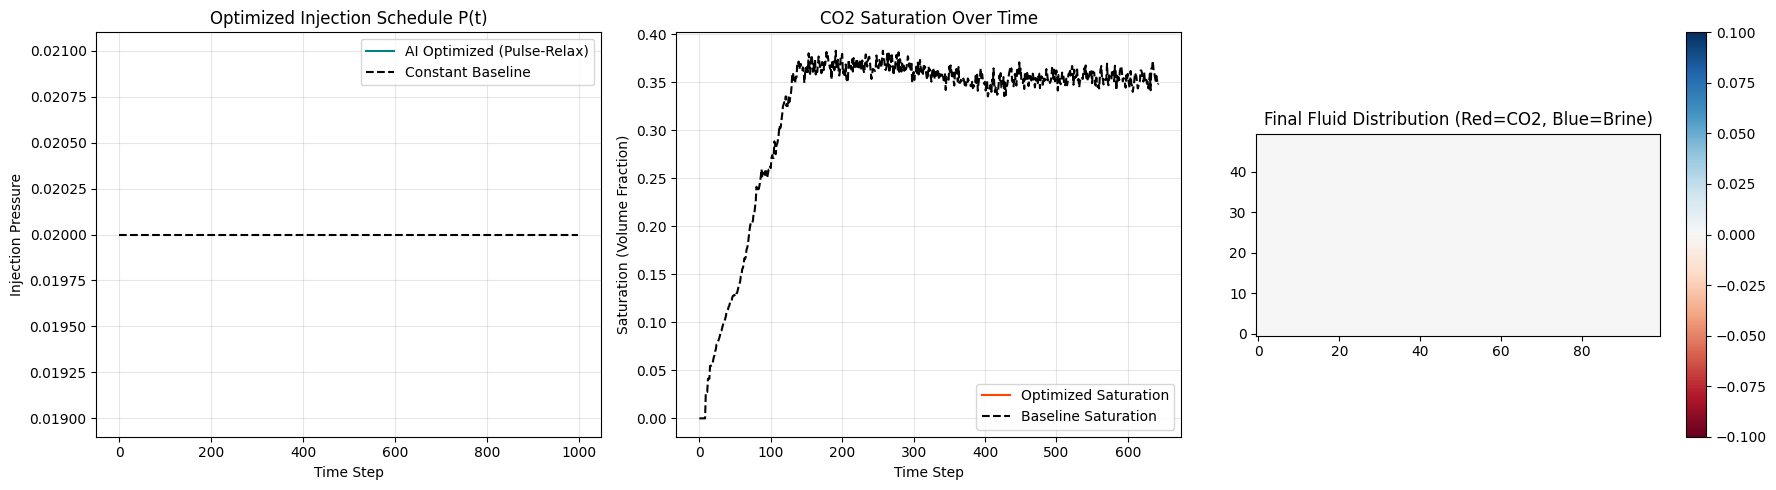

In [6]:
# Run final simulation with optimized schedule
final_state, s_hist_opt = run_simulation(pressure_params, state_init)
# Run baseline for comparison (Constant Pressure)
_, s_hist_base = run_simulation(jnp.ones(TIME_STEPS)*0.02, state_init) 

# Plotting
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# 1. The Optimized Injection Schedule
ax[0].plot(pressure_params, color='teal', label='AI Optimized (Pulse-Relax)')
ax[0].plot(jnp.ones(TIME_STEPS)*0.02, 'k--', label='Constant Baseline')
ax[0].set_title("Optimized Injection Schedule P(t)")
ax[0].set_xlabel("Time Step")
ax[0].set_ylabel("Injection Pressure")
ax[0].legend()
ax[0].grid(True, alpha=0.3)

# 2. Saturation Improvement
ax[1].plot(s_hist_opt, color='orangered', label='Optimized Saturation')
ax[1].plot(s_hist_base, 'k--', label='Baseline Saturation')
ax[1].set_title("CO2 Saturation Over Time")
ax[1].set_xlabel("Time Step")
ax[1].set_ylabel("Saturation (Volume Fraction)")
ax[1].legend()
ax[1].grid(True, alpha=0.3)

# 3. Final Fluid Distribution
# Extract density from final state to show fluid distribution
f_final, _, _ = final_state
rho_final = jnp.sum(f_final, axis=-1)
im = ax[2].imshow(rho_final.T, cmap='RdBu', origin='lower')
ax[2].set_title("Final Fluid Distribution (Red=CO2, Blue=Brine)")
plt.colorbar(im, ax=ax[2])

plt.tight_layout()
plt.show()